# Analysis of weekday prices

It seems that stock prices have tendency to go up on Mondays and go down Friday.
Here is quick analysis of weekday prices in 2015-2020

## Step 1: Getting S&P 500 data

In [3]:
import pandas as pd

import yfinance as yf
import os
from pandas.core.frame import DataFrame
from more_itertools.recipes import flatten

# Save csv file from https://datahub.io/core/s-and-p-500-companies to 'sp500.csv'
df = pd.read_csv("sp500.csv")
df.head()

,Symbol,Name,Sector
0,MMM,3M Company,Industrials
1,AOS,A.O. Smith Corp,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie Inc.,Health Care
4,ABMD,ABIOMED Inc,Health Care


# Step 2: Get stock price histories for 2015-2020

In [4]:
START_DATE = "2015-08-28"
END_DATE = "2020-08-28"

def get_history(symbol):
    ticker = yf.Ticker(symbol)
    df = ticker.history(period="1d", start=START_DATE, end=END_DATE)
    if not df.empty:
        df["Symbol"] = symbol
    return df

get_history(df["Symbol"][0]).head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol
Date,,,,,,,,
2015-08-27,122.460614,123.482892,120.399018,122.588394,4104600,0.0,0,MMM
2015-08-28,121.838692,122.946165,121.651274,122.852455,2664100,0.0,0,MMM
2015-08-31,121.821639,122.528717,120.986781,121.089005,2514900,0.0,0,MMM
2015-09-01,118.822910,119.683337,117.510991,117.988052,3671400,0.0,0,MMM
2015-09-02,119.725964,120.322304,118.618505,120.322304,3312700,0.0,0,MMM


## Step 3: Get differences between Monday and other weekday

In [5]:
def get_weekly_diffs(df):
    symbol = df["Symbol"][0]
    df = df.reset_index()
    df["weekday"] = df["Date"].apply(lambda x: x.weekday())

    if df[df["weekday"] == 0].empty:
        return {}

    # getting first row that starts with Monday
    df = df[df[df["weekday"] == 0].index[0] :]
    prev_monday_price = 0
    full_weeks = []
    is_monday = False
    is_friday = False
    week = []
    for _, row in df.iterrows():
        weekday = row["weekday"]
        # filter weeks were all days were traiding days
        is_monday = weekday == 0
        is_friday = weekday == 4

        if is_monday:
            prev_monday_price = row["Open"]
            price_diff = 1
            week = [row]
        else:
            if prev_monday_price == 0:
                continue
            price_diff = row["Open"] / prev_monday_price
            week.append(row)
        row["diff"] = price_diff

        if is_friday and len(week) == 5:
            full_weeks += week

    if not full_weeks:
        return {}

    df = DataFrame(full_weeks)

    df["Symbol"] = symbol
    return df.to_dict("r")

DataFrame(get_weekly_diffs(get_history(df["Symbol"][0]))).head()

/home/kirill/workspace/playground/.venv/lib/python3.8/site-packages/pandas/core/frame.py:1549: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol,weekday,diff
0,2015-08-31,121.821639,122.528717,120.986781,121.089005,2514900,0.0,0,MMM,0,1.000000
1,2015-09-01,118.822910,119.683337,117.510991,117.988052,3671400,0.0,0,MMM,1,0.975384
2,2015-09-02,119.725964,120.322304,118.618505,120.322304,3312700,0.0,0,MMM,2,0.982797
3,2015-09-03,120.918630,121.736447,120.381929,120.748253,2606200,0.0,0,MMM,3,0.992587
4,2015-09-04,119.214826,119.836709,118.550346,119.129631,3195800,0.0,0,MMM,4,0.978601


## Step 4: Find average weekday differences for all stocks

In [6]:
os.sys.path.append('../github/python_recipes/')
from utils.misc import concurrent_map

histories = []
for df_h in concurrent_map(get_history, symbols):
    if not df_h.empty:
        histories.append(df_h)

symbols_dfs = flatten(concurrent_map(get_weekly_diffs, histories))

df = DataFrame(symbols_dfs)
df = (
    df[["weekday", "diff"]]
    .groupby("weekday")
    .mean()
    .reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"])
)

df = df * 100
df.head()

NameError: name 'symbols' is not defined

,diff
Monday,0.000000
Tuesday,0.130351
Wednesday,0.190227
Thursday,0.080366
Friday,0.189618


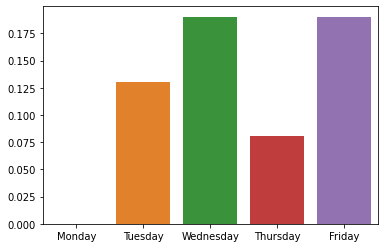

In [29]:
from seaborn import barplot
# index2weekday = dict(zip(range(0,5),['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday']))

df_percent_diff = df - 100
# df_percent_diff.index = [index2weekday[w] for w in df_percent_diff.index]
barplot(x=df_percent_diff.index, y=list(flatten(df_percent_diff.values)))
df_percent_diff